# Übung 3: Detektion mit Histogrammen

## Einführung

Objekte in einem Bild zu finden oder zu vergleichen kommt bei vielen Bildverarbeitungsproblemen zum Einsatz. Wenn sich ein Objekt in einer Farbe ganz klar von den anderen Bildinhalten abhebt, genügt es möglicherweise die entsprechende Farbe zu detektieren. Wie sieht es nun aber aus, wenn das Objekt keine einheitliche Farbe hat sondern mehrere Farben? Und wenn das Objekt vielleicht nicht immer in der gleichen Ansicht sichtbar ist?

Einen Ansatz bietet der Vergleich mittels Histogrammen. Das Histogramm des gesuchten Objekts dient als dessen Beschreibung (Modell). An jeder Position im Bild kann nun das Histogramms des umliegenden Bereichs, mit dem Histogramm des Objekts verglichen werden. Sind die Histogramme ähnlich, könnte sich das Objekt dort befinden. Als Vergleichsfunktion zwischen Histogrammen dient die Histogramm-Intersection oder die Bhattacharyya Distanz.


## Übung 1: Spieler Detektion

In den Beispielsbilder finden Sie Bilder von Fussballszenen. Sie sollen nun versuchen die Spieler einer Mannschaft zu detektieren.

Gehen Sie dazu wie folgt vor:

* Laden Sie das Bild und das Bild eines Spielers. Alternativ können sie später auch einen anderen Teil des Bilds ausschneiden. Sie haben nun 2 Bilder, eines das den Spieler enthält, den Sie suchen sollen (Modellbild) und das Bild auf dem Sie suchen sollen (Suchbild). Ihr Testprogramm soll diese beide Bilder als Input erhalten.

* Lesen Sie die Bilder ein und berechnen Sie das Histogramm des Modellbilds. Merken Sie sich auch die Grösse. 

* Berechnen Sie nun an jedem Bildpunkt (oder an jedem n-ten Punkt, falls die Berechnung zu lange dauert) im Suchbild das Histogramm aus einem Bildausschnitt, der der Grösse des gesuchten Modells entspricht. 

* Vergleichen Sie die beiden Histogramme mit einer geeigneten Funktion. 

* Sie haben nun den Histogramm Vergleich an jedem Punkt berechnet. Wie sieht das Bild der Resultate des Histogram Vergleichs aus? Wo liegt das Maximum?

* Wo haben Sie Spieler gefunden? Zeichnen Sie entsprechende Rechtecke im Bild ein.

Wie könnten Sie die Maximumssuche verbessern?



In [1]:
# OpenCV needs to be included first
import cv2
import numpy as np

# for displaying images in jupyter

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 200

(966, 1600, 3)
(142, 58, 3)


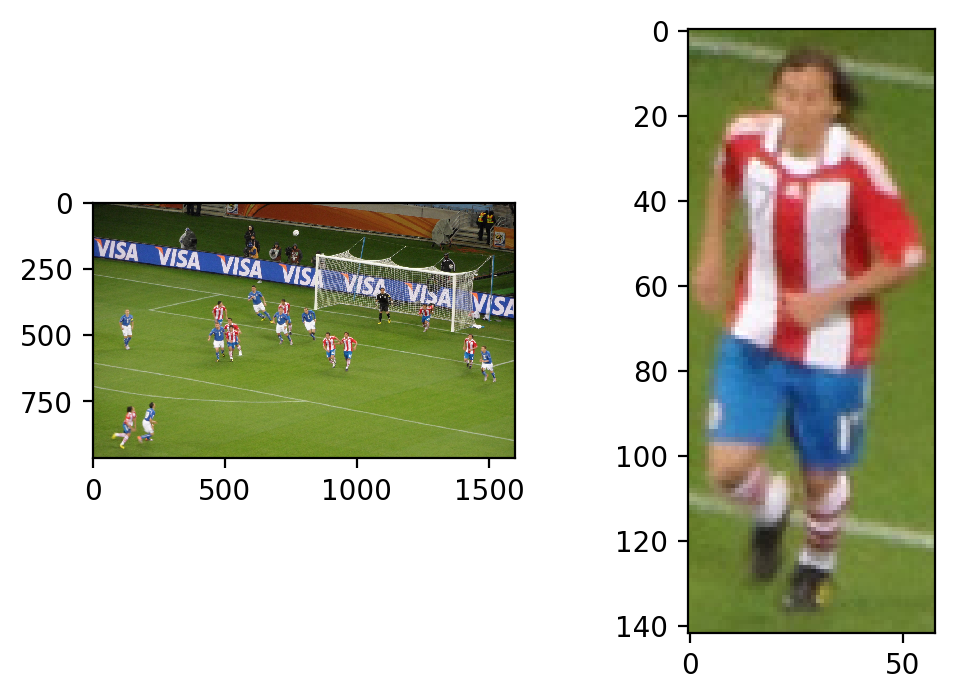

In [145]:
player  = cv2.imread('images/player.jpg')
player = cv2.cvtColor(player, cv2.COLOR_BGR2RGB)
image = cv2.imread('images/soccer-game.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(player)
print(image.shape)
print(player.shape)

#### Histogramme berechnen
Berechnen Sie als erstes das Histogram des Spielers. Beachten Sie dabei die Dokumentation der Histogrammberechnung in OpenCV. Sie können das Histogramm über 1, 2 oder 3 Farbkanäle berechnen. Für den besseren Vergleich eignen sich vielleicht andere Farbmodelle besser als RGB. 

Berechnen Sie als erstes ein 2 Kanal Histogram und stellen Sie dieses dar.

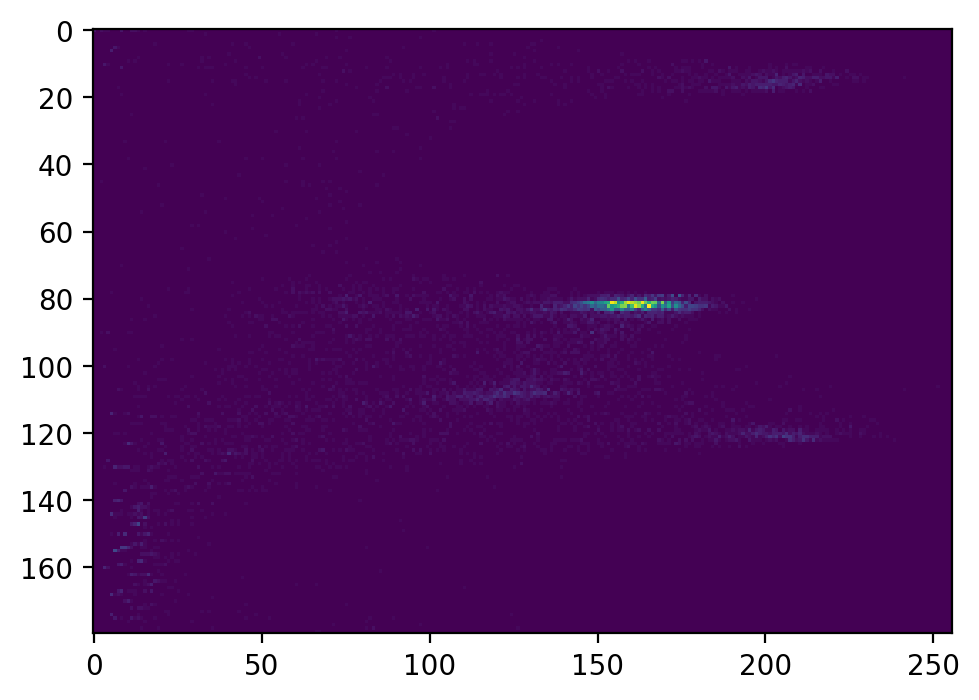

In [84]:
player_hsv = cv2.cvtColor(player, cv2.COLOR_RGB2HSV)

# the second parameter is the indexes of the channels. 0 and 1 means Hue and Saturation. 
# for every channel, you then need to specify ranges. Hue is 0-180 in opencv, Saturation 0-255.
hist_player = cv2.calcHist([player_hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
plt.imshow(hist)

#### Vergleich

Um Histogramme zu vergleichen, kann in OpenCV die Funktion `compareHist()` verwendet werden. Ein Parameter gibt dabei an, mit welcher Methode die Histogramme verglichen werden. Verbreitete und geeignete Methoden sind die Bhattacharyya Distanz oder die Kullback-Leibler Divergenz. Testen Sie beide Methoden in dem Sie das obige Histogramm mit sich selber vergleichen.

In [85]:
dist_bhatt = cv2.compareHist(hist_player, hist_player, cv2.HISTCMP_BHATTACHARYYA)
dist_kl = cv2.compareHist(hist_player, hist_player, cv2.HISTCMP_KL_DIV)
print('Bhat: {}, KL: {}'.format(dist_bhatt, dist_kl))

Bhat: 0.0, KL: 0.0


Extrahieren Sie nun einen anderen (beliebigen) Bereich im Bild und berechnen Sie darauf das Histogramm, stellen Sie es dar und vergleichen Sie es mit demjenigen des Spielers.

Bhat: 0.687173165028626, KL: 109866.99547421014


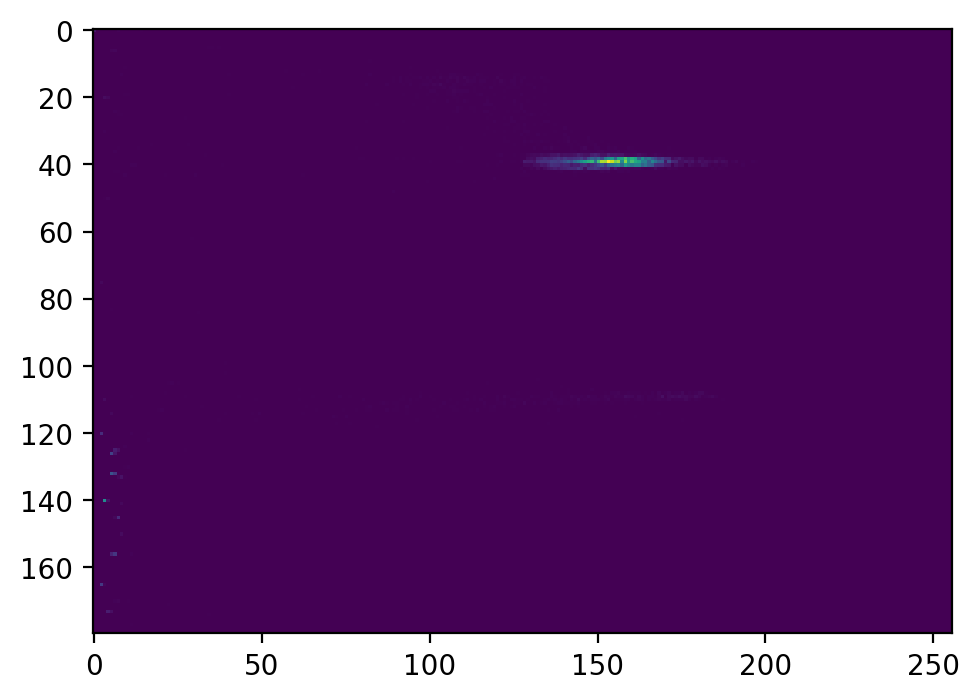

In [102]:
#slice part of image
sub_image = image[400:500, 0:200,:]

sub_image = cv2.cvtColor(sub_image, cv2.COLOR_RGB2HSV)
hist_sub_image = cv2.calcHist([sub_image], [0, 1], None, [180, 256], [0, 180, 0, 256]) 
plt.imshow(hist_sub_image)

dist_bhatt = cv2.compareHist(hist_player, hist_sub_image, cv2.HISTCMP_BHATTACHARYYA)
dist_kl = cv2.compareHist(hist_sub_image, hist_player, cv2.HISTCMP_KL_DIV)
print('Bhat: {}, KL: {}'.format(dist_bhatt, dist_kl))

Sind die Histogrammvergleiche kommutativ?

--> Nein, sind sie nicht. Es spielt eine Rolle, welche Histogramm zuerst steht

#### Player Detection

Iterieren Sie nun über das Bild und finden Sie Spieler in dem Sie das Histogramm des Spielers mit den Bildauschnitten vergleichen und den resultierenden Wert in einem Array festhalten. Der Vergleich an jedem Punkt ist wahrscheinlich (für die ersten Tests) zu aufwendig, sie könnten aber zum Beispiel jeden n-ten Punkt anschauen.

Wandeln Sie das resultierende Array in ein Bild um und stellen Sie dieses dar. Falls dazu die Auflösung im Browser zu klein ist, können Sie das Bild auch speichern (mittels `cv2.imwrite()`).

In [87]:
def sliding_windows(image, window_size, step_size=10):
    print(image.shape)
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (y, x, image[y:y+window_size[0], x:x+window_size[1]])

(142, 58) (966, 1600)
(966, 1600, 3)


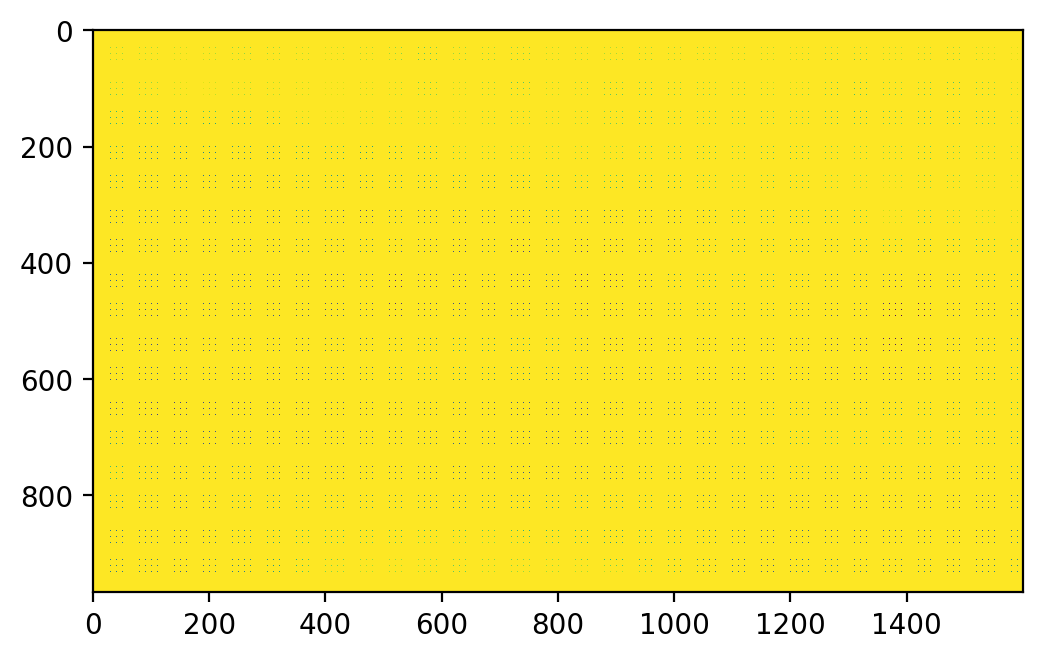

In [97]:
player_hsv = cv2.cvtColor(player, cv2.COLOR_RGB2HSV)

step_size = 10
player_shape = (player.shape[0], player.shape[1])
result_shape = (image.shape[0], image.shape[1])
print(player_shape, result_shape)
result = np.ones(result_shape)

for y, x, sliding_window in sliding_windows(image_hsv, player_shape, step_size):
    sliding_window_hist = cv2.calcHist([sliding_window], channels=[0,1], mask=None, histSize=[180, 256], ranges=[0, 180, 0, 256])  
    dist_bhatt = cv2.compareHist(sliding_window_hist, hist_player, cv2.HISTCMP_BHATTACHARYYA)
    result[y,x] = dist_bhatt
plt.imshow(result)

#### Resultat einzeichnen

Finden Sie nun die Stelle im Bild wo das Histogramm am besten passt (`cv2.minMaxLoc(...)`)und markieren Sie diese. Dazu können Sie zum Beispiel mit `cv2.circle(...)` einen Kreis im Bild zeichnen.


(1410, 500)


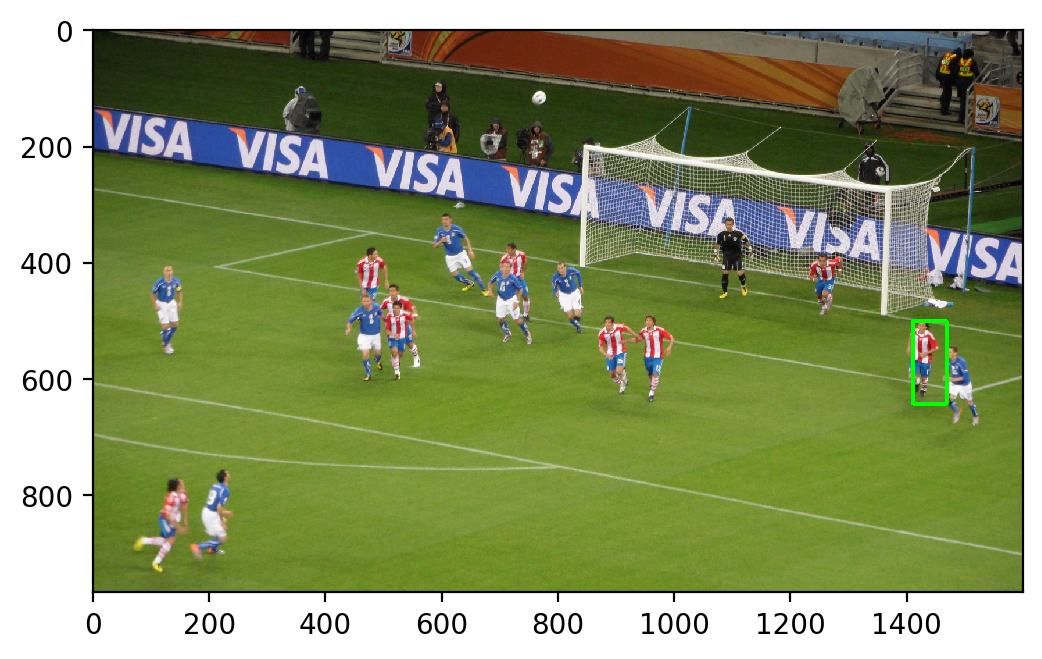

In [146]:
result_loc = cv2.minMaxLoc(result)
print(result_loc[2])

image_res = cv2.rectangle(image, result_loc[2], (result_loc[2][0]+player_shape[1], result_loc[2][1]+player_shape[0]), (0,255,0),5)
#image_res = cv2.rectangle(image, (1429 , 500), (result_loc[2][0]+player_shape[1], result_loc[2][1]+player_shape[0]), (0,255,0),5)
plt.imshow(image_res)

#### Abgabe auf Illias

Geben Sie auf Illias die ungefähren gefundenen Koordinaten des Spielers ein (plus/minus 10 Pixel).